# Transfer Learning - MobileNetV2

In [1]:
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix

import tensorflow as tf

In [2]:
train_dir = '/Users/amirreza/Desktop/Metis_ds_ml/Metis_DSML/Projects/6_Deep_Learning_COVID19_Chest_Xray/output/train'
val_dir = '/Users/amirreza/Desktop/Metis_ds_ml/Metis_DSML/Projects/6_Deep_Learning_COVID19_Chest_Xray/output/val'
test_dir = '/Users/amirreza/Desktop/Metis_ds_ml/Metis_DSML/Projects/6_Deep_Learning_COVID19_Chest_Xray/output/test'

In [3]:
IMG_HEIGHT = 224
IMG_WIDTH = 224

BATCH_SIZE = 32

### Generating the Data

In [4]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    brightness_range=(1.2, 1.5),
    horizontal_flip=True
)

val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)

In [5]:
train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    class_mode='binary',
    batch_size=BATCH_SIZE
)

val_data = train_datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    class_mode='binary',
    batch_size=BATCH_SIZE
)

test_data = train_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    class_mode='binary',
    batch_size=BATCH_SIZE
)

Found 3650 images belonging to 2 classes.
Found 521 images belonging to 2 classes.
Found 1045 images belonging to 2 classes.


### Model

In [6]:
mobilenet = tf.keras.applications.MobileNetV2(
    input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

mobilenet.trainable = False

2021-12-02 11:27:44.638283: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [7]:
inputs = tf.keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))

pretrained_model = mobilenet(inputs, training=False)

dense = tf.keras.layers.Dense(128, activation='relu')(pretrained_model)

outputs = tf.keras.layers.Dense(1, activation='sigmoid')(dense)


model = tf.keras.Model(inputs, outputs)


print(model.summary())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 128)               163968    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 2,422,081
Trainable params: 164,097
Non-trainable params: 2,257,984
_________________________________________________________________
None


In [8]:
EPOCHS = 30

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.AUC(name='auc')
    ]
)

history = model.fit(
    train_data,
    validation_data=val_data,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=3,
            restore_best_weights=True
        )
    ]
)

2021-12-02 11:27:47.781323: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/30
115/115 [==============================] - 210s 2s/step - loss: 0.2493 - accuracy: 0.8893 - auc: 0.9459 - val_loss: 0.1346 - val_accuracy: 0.9367 - val_auc: 0.9902
Epoch 2/30
115/115 [==============================] - 173s 2s/step - loss: 0.1332 - accuracy: 0.9468 - auc: 0.9857 - val_loss: 0.0822 - val_accuracy: 0.9655 - val_auc: 0.9956
Epoch 3/30
115/115 [==============================] - 173s 2s/step - loss: 0.1075 - accuracy: 0.9584 - auc: 0.9907 - val_loss: 0.1101 - val_accuracy: 0.9578 - val_auc: 0.9920
Epoch 4/30
115/115 [==============================] - 176s 2s/step - loss: 0.1118 - accuracy: 0.9556 - auc: 0.9892 - val_loss: 0.0821 - val_accuracy: 0.9674 - val_auc: 0.9949
Epoch 5/30
115/115 [==============================] - 175s 2s/step - loss: 0.0994 - accuracy: 0.9597 - auc: 0.9921 - val_loss: 0.0933 - val_accuracy: 0.9578 - val_auc: 0.9946
Epoch 6/30
115/115 [==============================] - 171s 1s/step - loss: 0.0940 - accuracy: 0.9638 - auc: 0.9926 - val_loss

In [9]:
model.save('model_mobilenetv2_data.h5')

/Users/amirreza/opt/anaconda3/envs/metis/lib/python3.8/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


## Results

In [10]:
true_labels = test_data.labels
pred_labels = np.squeeze(np.array(model.predict(test_data) >= 0.5, dtype=np.int))

cm = confusion_matrix(true_labels, pred_labels)

/var/folders/3b/d88c396s1jx1hf72ltg_cc4r0000gn/T/ipykernel_60664/1857651140.py:2: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_labels = np.squeeze(np.array(model.predict(test_data) >= 0.5, dtype=np.int))


In [11]:
test_data.class_indices

{'NORMAL': 0, 'PNEUMONIA': 1}

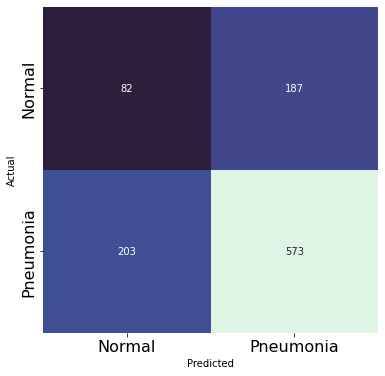

In [12]:
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='mako', cbar=False)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.xticks(np.arange(2) + 0.5, ['Normal', 'Pneumonia'], fontsize=16)
plt.yticks(np.arange(2) + 0.5, ['Normal', 'Pneumonia'], fontsize=16)
plt.show()

In [13]:
results = model.evaluate(test_data, verbose=0)

accuracy = results[1]
auc = results[2]

In [14]:
tn, fp, fn, tp = cm.ravel()

precision = tp / (tp + fp)
recall = tp / (tp + fn)

print("Accuracy: {:.2f}".format(accuracy))
print("AUC: {:.2f}".format(auc))
print("Precision: {:.2f}".format(precision))
print("Recall: {:.2f}".format(recall))

Accuracy: 0.97
AUC: 0.99
Precision: 0.75
Recall: 0.74


In [16]:
from sklearn.metrics import classification_report
print(classification_report(true_labels, pred_labels))

              precision    recall  f1-score   support

           0       0.29      0.30      0.30       269
           1       0.75      0.74      0.75       776

    accuracy                           0.63      1045
   macro avg       0.52      0.52      0.52      1045
weighted avg       0.63      0.63      0.63      1045

